## Wetting Ridge fit

### Shanahan Model
10.1021/la00004a055

$$\begin{equation*}
\zeta = \cfrac{\gamma_l\sin\theta}{2\pi G}\ln\left(\cfrac{d}{|x|}\right)
\end{equation*}$$

### Limat Model
10.1140/epje/i2012-12134-6

$$\begin{equation*}
\begin{split}
\zeta_S &= \cfrac{\gamma_l\sin\theta}{2\pi G}\left[\cfrac{l_S+x}{R}\log\cfrac{l_S+x+R}{l_S+x-R}-2\right],\hspace{1em} \mathrm{for} \hspace{1em} x>R\\
\zeta_S &= \cfrac{\gamma_l\sin\theta}{2\pi G}\left[\cfrac{l_S}{R}\log\cfrac{l_S+x+R}{l_S} + \cfrac{l_S}{R}\log\cfrac{l_S-x+R}{l_S}+\cfrac{x}{R}\log\cfrac{l_S+x+R}{l_S-x+R}-2\right], \hspace{1em} \mathrm{for} \hspace{1em} 0<x<R\\
\end{split}
\end{equation*}$$

$l_S = \cfrac{\gamma_S}{\pi G}$

### Style and Dufresne Model
10.1039/C2SM25540E  

#### Large Droplets on thin substrate

$\overline{x} = \frac{r-R}{h} $, 
$\overline{s} = sh$

$\nu = 0.5, G\approx\frac{E}{3} \rightarrow$  
$$\begin{equation*}
\begin{split}
\displaystyle u_z(\overline{x})
&= \cfrac{ \gamma_l }{2\pi G} \cdot \intop_0^\infty d\overline{s} \cfrac{\cos (\overline{sx})}{{\cfrac{1+2\overline{s}²+\cosh(2\overline{s})}{\sinh(2\overline{s})-2\overline{s}}\overline{s}+ \cfrac{\varUpsilon_s}{2Gh}\overline{s}^2}}\\
& =  \cfrac{ \gamma_l }{2\pi G} \cdot \intop_0^\infty d\overline{s} \cfrac{\cos (\overline{sx})}{{\cfrac{(1+2\overline{s}²)e^{-2\overline{s}}+\frac{1}{2}(1+e^{-4\overline{s}})}{\frac{1}{2}(1-e^{-4\overline{s}})-2\overline{s}e^{-2\overline{s}}}\overline{s}+ \cfrac{\varUpsilon_s}{2Gh}\overline{s}^2}}
\end{split}
\end{equation*}$$

#### General Asymmetric Form

$\nu = 0.5, G\approx\frac{E}{3}, z=h \rightarrow$  

$$\begin{equation*}
\begin{split}
u_z(\overline{x}) 
&= \gamma_l \intop_0^\infty ds \left[RJ_0(sR)-2\cfrac{J_1(sR)}{s}\right] \cfrac{3}{2sE} \left(\cfrac{1+2s²h²+\cosh(2sh)}{\sinh(2sh)-2sh}+ \cfrac{\varUpsilon_s}{2G}s\right)^{-1}\\ 
&= \gamma_l \intop_0^\infty ds \left[RJ_0(sR)-2\cfrac{J_1(sR)}{s}\right] \cfrac{3}{2sE} \left(\cfrac{(1+2s²h²)e^{-2sh}+\frac{1}{2}(1+e^{-4sh})}{\frac{1}{2}(1-e^{-4sh})-2she^{-2sh}}+ \cfrac{\varUpsilon_s}{2G}s\right)^{-1} 
\end{split}
\end{equation*}
$$

$h$: Substrate thickness,    $R$: Droplet radius, $\nu$: Poisson ratio,    $\gamma_l$: liquid vapour surface tension  
$\varUpsilon_s$: solid surface stress,   $E$: Elastic modulus,   $G$: Shear moulus  
$J_0, J_1$: Bessel functions of the first kind

In [1]:
from ridge_extractor import extract_ridge_from_image, find_features
from ridge_profile_fit import fit_profile
from skimage.draw import circle_perimeter
from pathlib import Path
import pandas as pd
import pickle
import numpy as np

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap")
# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params = {\
    "h" : {"thick": 0.002, "thin": 0.0002},
    "E_lookup" : {"70_S":12000,"70_H":30000,"80_S":60000,"80_H":105000},
    "upsilon" : 0.059, # from 10.1002/marc.202000360
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # 10.1038/ncomms5369, 10.1103/PhysRevLett.109.038001
    "theta": 100
}

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


## Preprocessing

In [9]:
# convert numpy arrays from gwyddion to tiffs
import subprocess
from subprocess import run, PIPE, STDOUT
from pathlib import Path
import numpy as np
import json

# preprocess all files
print("-- Preparing data -- ")
#use pathlib to get current working dir
cwd = Path.cwd()
print(cwd)
glb = source_dir.rglob("*_f*.lext")

for file in glb:
    python2_command = f'C:/Python27/python.exe -W ignore {cwd/"gwypy_lext_processing.py"} -o {Path(file).with_suffix("")} "{Path(file)}"'
    ret = subprocess.check_output(python2_command)
    print(ret.decode())


# import numpy as np
# import tifffile

# glb = source_dir.rglob("*f.npz")
# for file in glb:
#     arr: np.ndarray = np.load(file)["arr_0"]
#     with open(file.with_stem(file.stem +"_img_attr").with_suffix(".txt")) as f:
#         lines = f.readlines()
#         pixelscale =[float(x) for x in lines[2].split(" ")[-2].strip().split(",")]
#     metadata=dict(microscope="LEXT", PhysicalSizeX=pixelscale[0], PhysicalSizeY=pixelscale[1], PhysicalSizeUnit="m")
#     tifffile.imwrite(Path(file).with_suffix(".ome.tif"), arr, 
#                     compression="zlib", compressionargs={'level':9}, tile=(256,256), maxworkers=8,
#                     metadata=metadata, shape=arr.shape, dtype=arr.dtype,
#                     resolution=(1/pixelscale[0], 1/pixelscale[1]), resolutionunit=None)

-- Preparing data -- 
c:\Users\krr38985\Documents\Python\ridge_evaluation
Evaluating Surface Data ...
From files:
['D:\\Messungen\\Profilometry\\Lasermikroskop\\Wetting_Ridge\\70vs80_evap\\70_S_1_thick_blow_f.lext']
Target path: D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap\70_S_1_thick_blow_f
Loading file D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap\70_S_1_thick_blow_f.lext
1
Applying transformations
Smoothing
Exporting results ...
(1577229.798311636, 1580060.0422222707)
Done

Evaluating Surface Data ...
From files:
['D:\\Messungen\\Profilometry\\Lasermikroskop\\Wetting_Ridge\\70vs80_evap\\70_S_1_thick_evap_f.lext']
Target path: D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap\70_S_1_thick_evap_f
Loading file D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap\70_S_1_thick_evap_f.lext
1
Applying transformations
Smoothing
Exporting results ...
(1577229.798311636, 1580060.0422222703)
Done

Evaluating Surface Dat

## Comparisson Real vs Function

### Analyze

In [10]:
from data_types import RidgeFit, RidgeFitMethod
from skimage.transform import rescale
# Extract ridge from images and store as csv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
# import numba as nb
from ridge_models import style_exact, style_ld_ts, shanahan, limat_symmetric
# from scipy.signal import savgol_filter
import asyncio

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap")
# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":1200,"70_H":3000,"80_S":3000,"80_H":10500},
    "upsilon" : 0.059, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}


# https://stackoverflow.com/a/59385935/9173710

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

def _fit_calc(radial_coord, gamma, radius, popt, downscale_factor):
    radial_resized = rescale(radial_coord, downscale_factor, anti_aliasing=False)
    img_calc = np.zeros_like(radial_resized)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_resized[i,:], gamma, radius, *popt)
    return img_calc

@background
def compare_fit_with_original(file):
    try:
        downscale_factor = 0.1
        ridge, image, circ_params, rim_binarized, r2, pixelscale = \
                extract_ridge_from_image(file, robust=True, threshold=0.55, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
        yc,xc,r = circ_params
        # rolling average
        x_r, y_r = ridge
        # y_r = np.convolve(y_r, np.ones(10), 'same') / 10
        # y_r = savgol_filter(y_r, 500, 2)
        print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")
        df = pd.DataFrame({"x":x_r,"y":y_r})
        df.to_csv(file.with_suffix(".rdg"), sep=";")

        fits: dict[str, RidgeFit] = fit_profile(file.with_suffix(".rdg"), **initial_params)

        ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
        x_values = np.arange(image.shape[1])*pixelscale[0] - xcs
        y_values = np.arange(image.shape[0])*pixelscale[1] - ycs

        # radial_coord = np.zeros((image.shape[0], image.shape[1]))

        x_grid,y_grid = np.meshgrid(x_values, y_values)
        radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
        # angle_coord = np.arctan2(y_grid, x_grid)

        img_calc = _fit_calc(radial_coord, fits["style"].gamma, fits["style"].radius, fits["style"].popt, downscale_factor=downscale_factor)
        # img_calc = style_exact(radial_coord, fits["style"].gamma, r, *fits["style"].popt)

        pickle.dump((yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge), open(file.with_suffix(".pkl"), "wb"))

    except Exception as e:
            print(e)
            print(file)
            raise

        # raise

glb = source_dir.rglob("*_f*.ome.tif")
futures = list()

sem = asyncio.Semaphore(4)
for file in glb:

    # compare_fit_with_original(file, pandas_data)
    async with sem:
        futures.append(compare_fit_with_original(file))



res = await asyncio.gather(*futures)
          
# asyncio.get_event_loop().run_until_complete(asyncio.gather(*futures))
# asyncio.get_event_loop().close()


### Tables

In [4]:
# build df
pandas_list = list()
glb = source_dir.rglob("*.pkl")
for file in glb:
    Fe, G, vol, th, *_ = Path(file).stem.split("_")
    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge = pickle.load(f)
    # export
    pandas_list.append(pd.DataFrame({"model":list(fits.keys()),
                            "hardness":[f.shear_mod for f in fits.values()], 
                            "volume":[f.volume for f in fits.values()], 
                            "iron":[f.iron_content for f in fits.values()],
                            "e_mod_fit":[f.popt[-2] for f in fits.values()],
                            "height": [f.popt[-1] if (f.fit_method >= RidgeFitMethod.STYLE_LD) else initial_params["h"][th] for f in fits.values()],
                            "thickness":[th]*len(fits),
                            "r2":[f.r2 for f in fits.values()]}))

pd.concat(pandas_list).to_csv(source_dir / "fit_data.csv", sep="\t")  

### Plots

70_S_1_thick_blow_f.ome - Style: ['ups: 0.045581', 'E: 268.64', 'h: 0.00010959'] (R2: 0.826) - Style_LD: ['ups: 0.0019251', 'E: 3920.4', 'h: 0.00085122'](R2: 0.345)


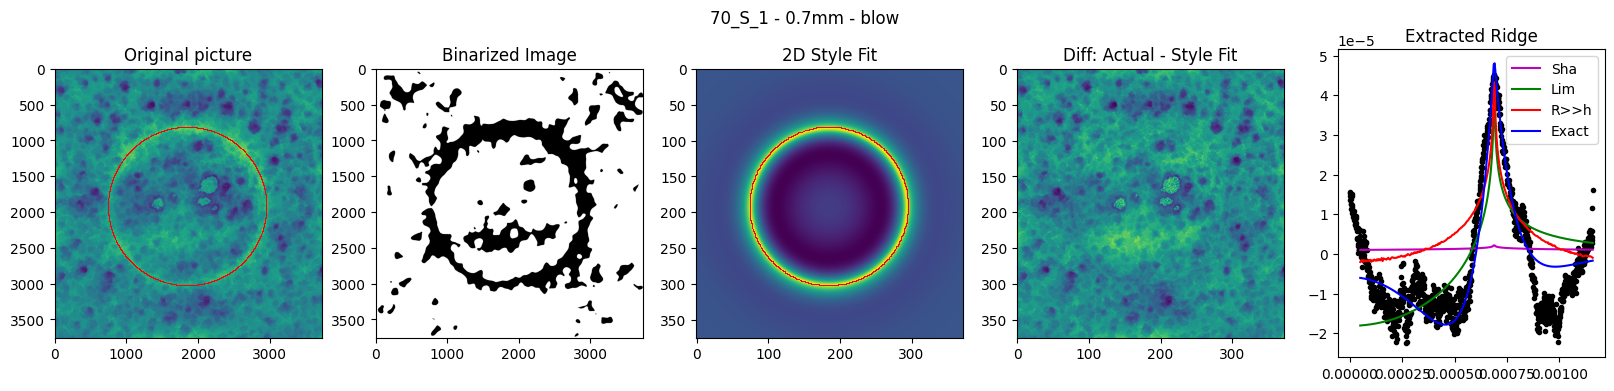

70_S_1_thick_evap_f.ome - Style: ['ups: 0.041044', 'E: 2035.8', 'h: 0.000203'] (R2: 0.687) - Style_LD: ['ups: 0.0018103', 'E: 6991.9', 'h: 0.0009013'](R2: 0.378)


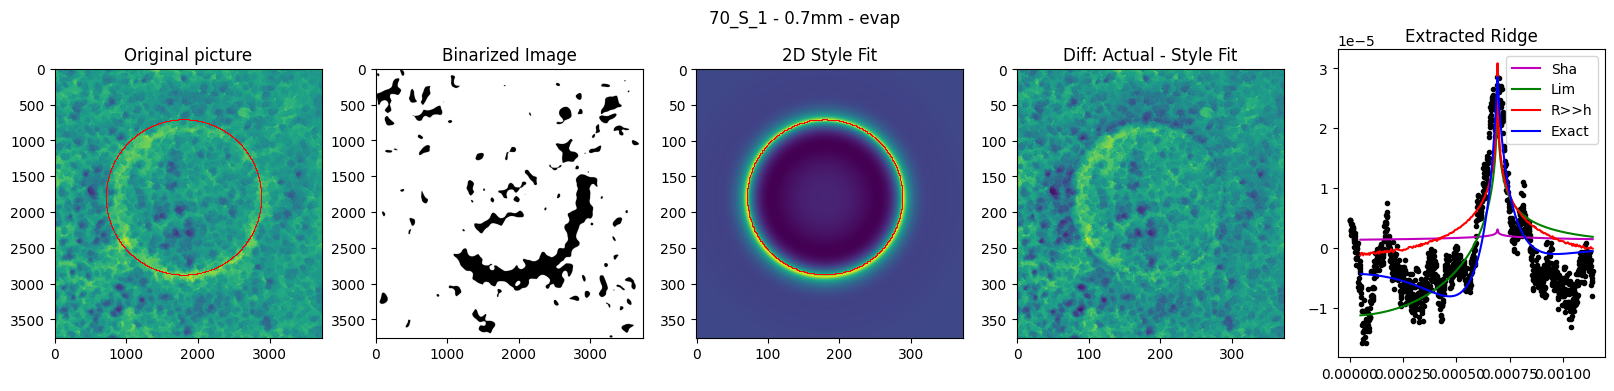

80_S_1_thick_blow_f.ome - Style: ['ups: 0.075207', 'E: 9553.8', 'h: 0.00081403'] (R2: -0.199) - Style_LD: ['ups: 0.050685', 'E: 8863.8', 'h: 0.00093759'](R2: 0.064)


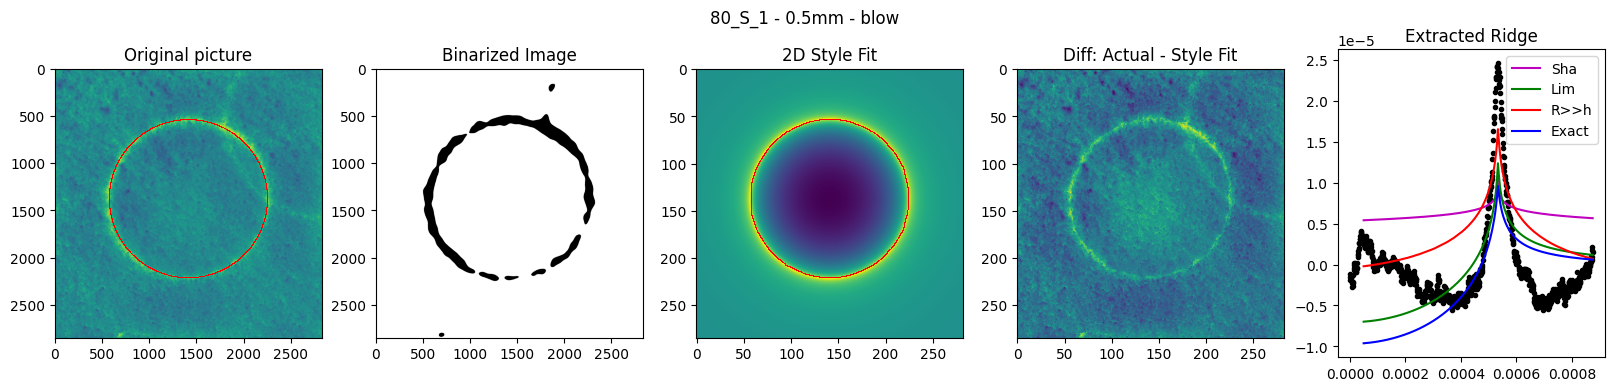

80_S_1_thick_blow_f_2.ome - Style: ['ups: 0.17503', 'E: 14673', 'h: 0.00039249'] (R2: 0.016) - Style_LD: ['ups: 0.022753', 'E: 9000', 'h: 0.00095604'](R2: -0.524)


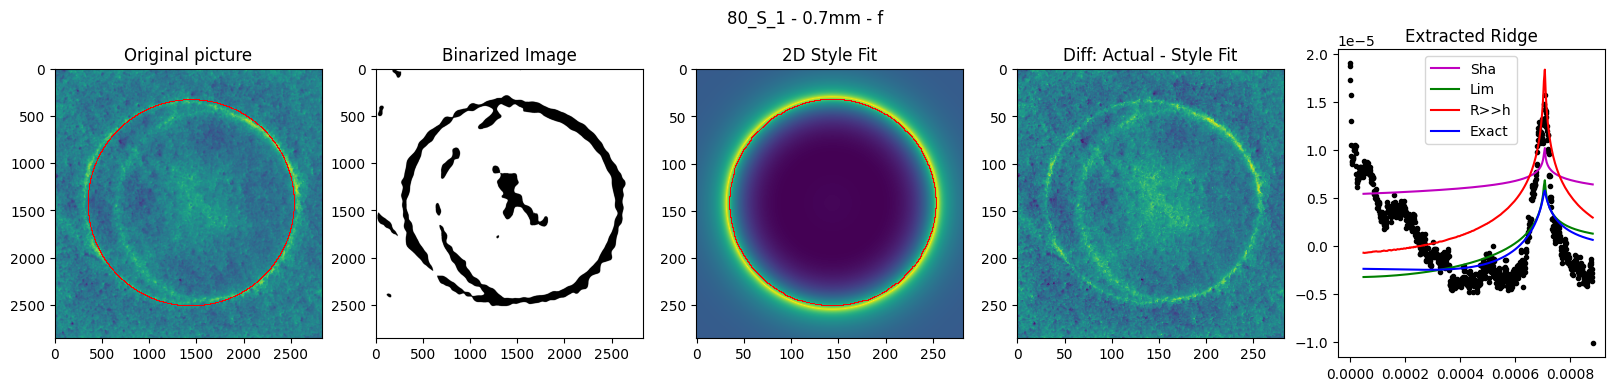

80_S_1_thick_evap_f.ome - Style: ['ups: 0.18361', 'E: 13056', 'h: 0.00040861'] (R2: 0.001) - Style_LD: ['ups: 0.013732', 'E: 9000', 'h: 0.00095613'](R2: -0.354)


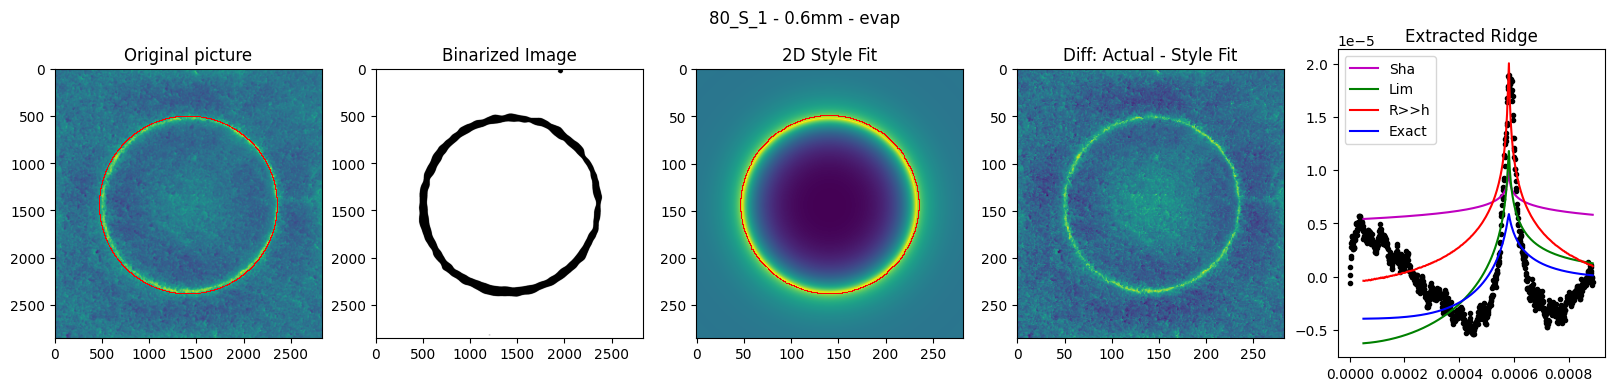

80_S_1_thick_evap_f_2.ome - Style: ['ups: 0.095775', 'E: 15000', 'h: 0.00039666'] (R2: -0.037) - Style_LD: ['ups: 0.068275', 'E: 9000', 'h: 0.00096159'](R2: -0.565)


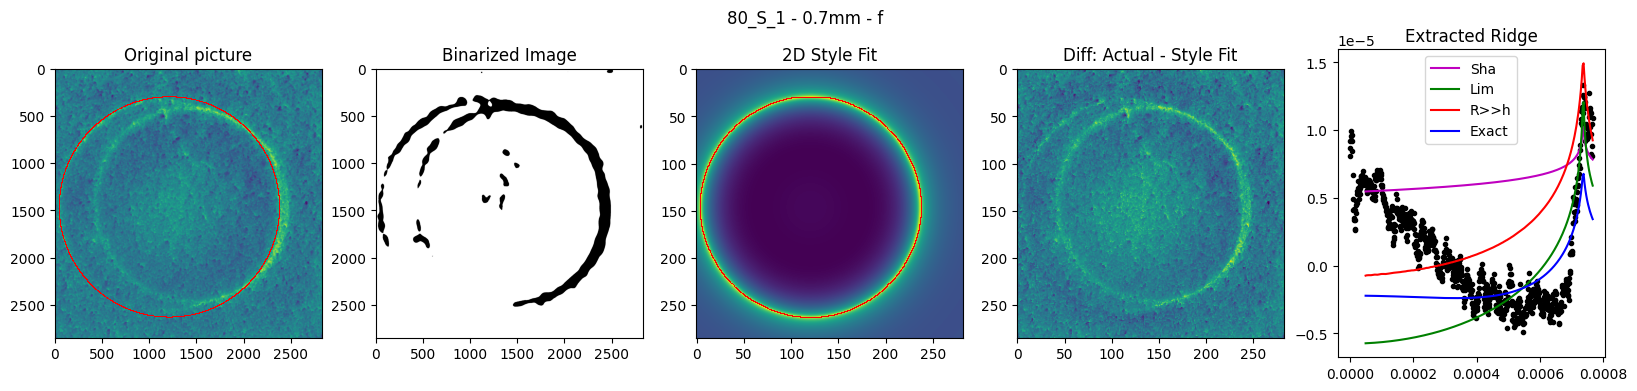

In [12]:

# for f in concurrent.futures.as_completed(futures):
#     print("ok")
    # break
glb = source_dir.rglob("*.pkl")
for file in glb:

    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge = pickle.load(f)
    cy, cx = circle_perimeter(yc,xc,r)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))
    fig.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume} - {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]}")
    ax1.set_title('Original picture')
    ax1.imshow(image)
    ax1.plot(cx,cy, "r,")

    ax2.set_title('Binarized Image')
    ax2.imshow(rim_binarized, cmap="Greys")

    ax3.set_title('2D Style Fit')
    ax3.imshow(img_calc)
    ax3.plot((cx*downscale_factor).astype(int), (cy*downscale_factor).astype(int), "r,")

    ax4.set_title('Diff: Actual - Style Fit')
    ax4.imshow(rescale(image, downscale_factor, anti_aliasing=False) - img_calc)
    
    ax5.set_title('Extracted Ridge')
    ax5.plot(ridge[0], ridge[1], "k.")
    fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)

    def _fit_helper(fits, model, x, ax):
        styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}
        label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
        fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
        rf = fits[model]
        ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
    rf = fits["style"]
    
    for model in fits.keys():
        if model == "actual": continue
        _fit_helper(fits, model, fit_x, ax5)
    
    #print model params of style and style_ld
    names = ("ups", "E", "h")
    style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
    style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
    print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")

    plt.legend()
    plt.show()
    fig.savefig(source_dir / "pics" / file.with_suffix(".png").name)